# Anisotropy sandbox notebook

In [1]:
# import packages
from imaris_ims_file_reader.ims import ims
import matplotlib.pyplot as plt
from pyclesperanto_prototype import imshow
import numpy as np
import utils.WTMM as WTMM
from skimage.draw import line

In [27]:
def show(images_to_show,titles):
    if len(images_to_show) == 1:
        fig, axs = plt.subplots(1, len(images_to_show))
        for i,img in enumerate(images_to_show):
            imshow(img, plot=axs,colormap='gray')
            axs.set_title(titles[i])
            axs.set_axis_off()
           
    else:
        fig, axs = plt.subplots(1, len(images_to_show), figsize=(15, 15))
        for i,img in enumerate(images_to_show):
            imshow(img, plot=axs[i],colormap='gray')
            axs[i].set_title(titles[i])
            axs[i].set_axis_off()
    plt.show()

In [3]:
path = "/Volumes/G_MLS_RB_UHOME$/qfavey/01_Experiments/F_Spinal Muscle Staining/F01-005/2024-05-16/WT_4D9-568_DAPI_Phalloidin-488_20x_F08.ims"
img = ims(path)
filename = path.split("/")[-1]

data = {}
print("input shape: ",img.shape)

data["Phalloidin"] = img[0,2,10,500:1300,500:1250]  #extract the Actub stack as max z projection
#data["Pkd2l1"] = cle.maximum_z_projection(img[0,0,:,:,:]) #extract the Pkd2l1 stack middle-width:middle+width
del img
#print("Pkd2l1: ", data["Pkd2l1"].shape)
print("Phalloidin: ", data["Phalloidin"].shape)


input shape:  (1, 3, 67, 2040, 1992)
Phalloidin:  (800, 750)


In [4]:
# Generate Gaussian noise with mean 0 and standard deviation 1, same shape as data["Phalloidin"]
#gaussian_noise = np.random.normal(loc=12, scale=10, size=data["Phalloidin"].shape)

# Assign the Gaussian noise to data["Phalloidin"]
# data["Noise"] = gaussian_noise

In [43]:
def generate_isotropic_image(num_lines=30, img_size=(100, 100), line_length=30, line_thickness=1, orientation=[0,180]):
    # Create an empty image
    img = np.zeros(img_size, dtype=np.uint8)

    # # Set random seed for reproducibility
    np.random.seed(0)

    # Generate random lines
    for _ in range(num_lines):
        x0, y0 = np.random.randint(0, img_size[0]), np.random.randint(0, img_size[1])
        
        angle = np.random.uniform(np.deg2rad(orientation[0])+np.pi/2, np.deg2rad(orientation[1])+np.pi/2)
        x1 = int(x0 + line_length * np.cos(angle))
        y1 = int(y0 + line_length * np.sin(angle))
        
        # Ensure the line endpoints are within image bounds
        x1 = np.clip(x1, 0, img_size[0] - 1)
        y1 = np.clip(y1, 0, img_size[1] - 1)

        # Draw the line
        rr, cc = line(x0, y0, x1, y1)
        img[rr, cc] = 255
    return img

In [44]:
# Get the shape of the data["Phalloidin"] array
shape = data["Phalloidin"].shape

data['0-180'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[0,180]) for i in range(0,100)]
data['70-95'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[70,95]) for i in range(0,100)]
data['30-150'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[30,150]) for i in range(0,100)]

print(np.shape(data['Phalloidin']))

(800, 750)


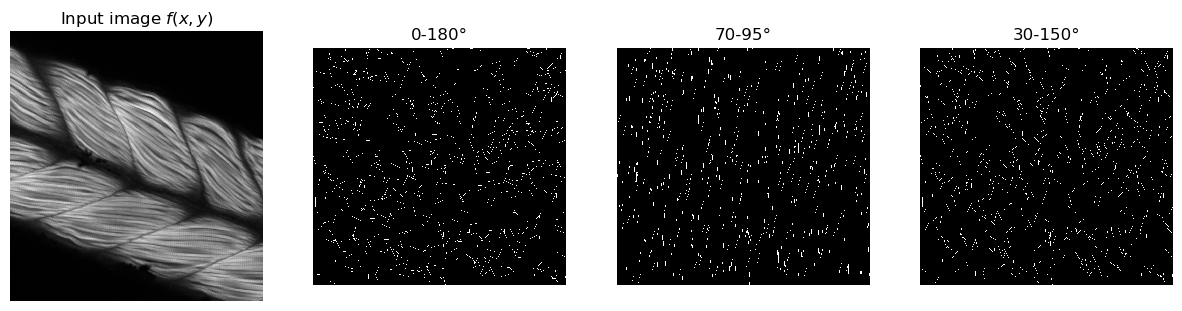

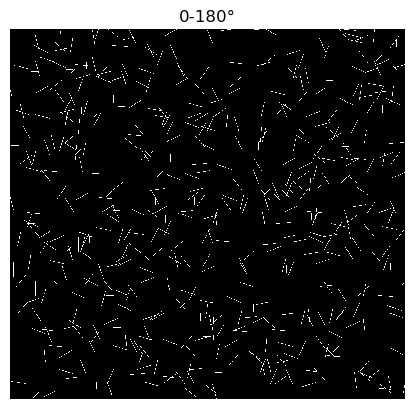

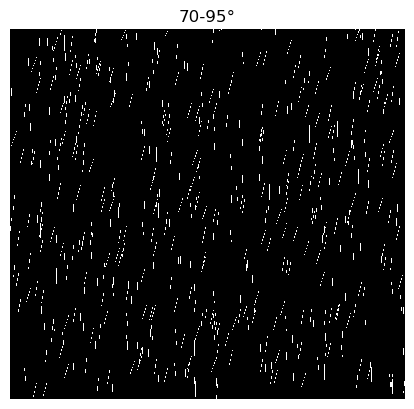

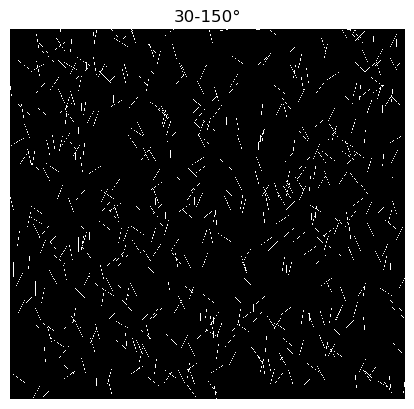

In [46]:
show([data['Phalloidin'],data['0-180'][0],data['70-95'][0],data['30-150'][0]],[r'Input image $f(x,y)$','0-180°','70-95°','30-150°'])
show([data['0-180'][0]],['0-180°'])
show([data['70-95'][0]],['70-95°'])
show([data['30-150'][0]],['30-150°'])

In [47]:
sim = {}
fish = WTMM.WTMM_compute(data['Phalloidin'],2,10)
sim["iso"] = WTMM.WTMM_compute(data['0-180'][0],2,1)
sim["70-95"] = WTMM.WTMM_compute(data['70-95'][0],2,1)
sim["30-150"] = WTMM.WTMM_compute(data['30-150'][0],2,1)

100%|██████████| 748/748 [00:00<00:00, 1978.96it/s]


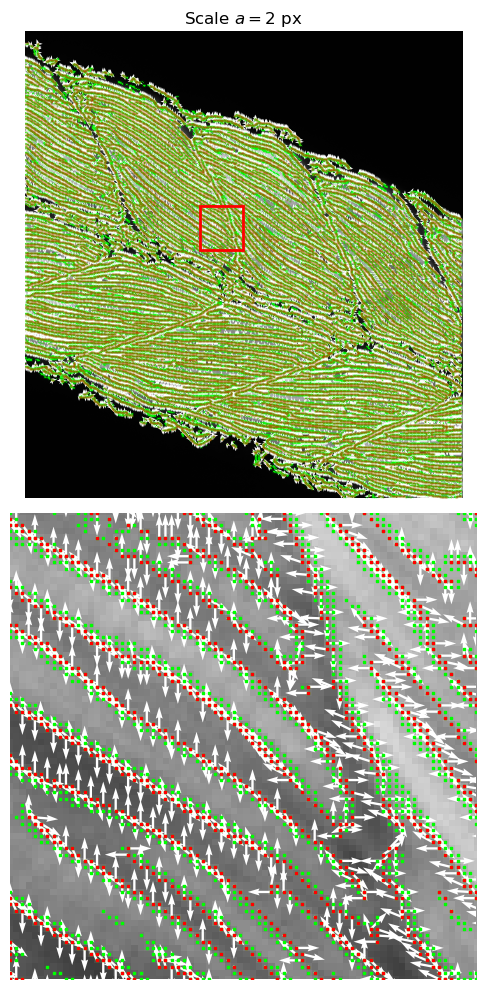

In [48]:
WTMM.plot_wavelet_transform2(fish,rect1=300,rect2=375)

/Users/quillan/Documents/Lab/Thesis/Muscle-fiber-anisotropy/utils/WTMM.py:254: RuntimeWarning: invalid value encountered in divide
  ax4.quiver(X_sub, Y_sub, U_sub/magnitude, V_sub/magnitude, units='width', width=0.002, scale=100, color='white')
/Users/quillan/Documents/Lab/Thesis/Muscle-fiber-anisotropy/utils/WTMM.py:268: RuntimeWarning: invalid value encountered in divide
  zoomed_ax.quiver(X_sub, Y_sub, U_sub/magnitude, V_sub/magnitude, units='width', width=0.005, scale=15, color='white')


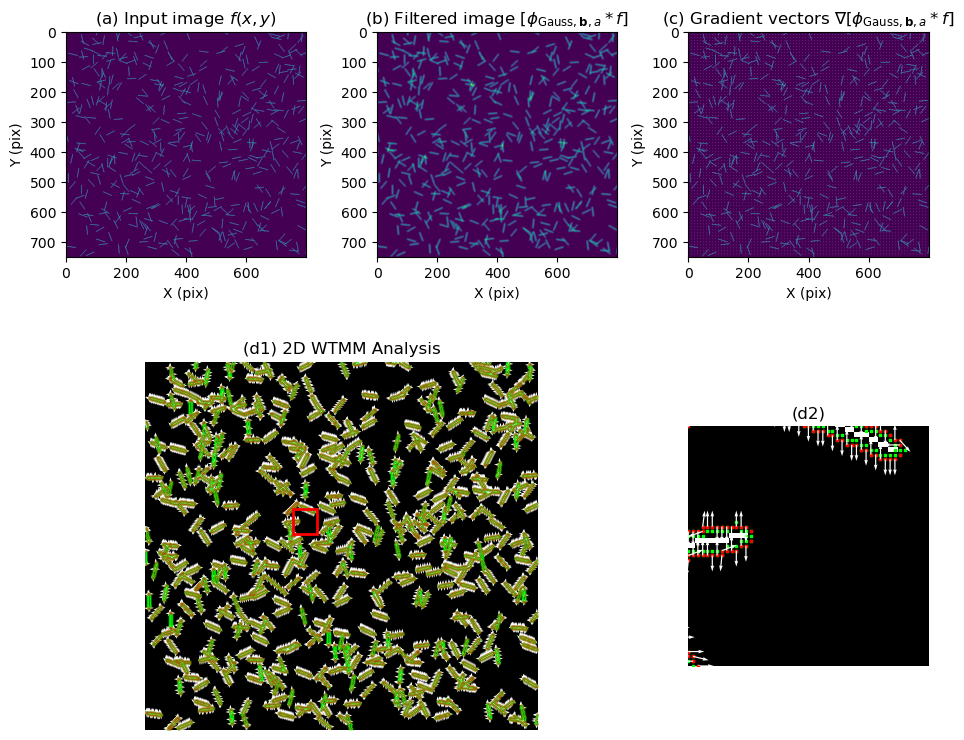

In [49]:
WTMM.plot_wavelet_transform(sim['iso'],step=10,rect1=300,rect2=350)

100%|██████████| 798/798 [00:00<00:00, 906.55it/s] 


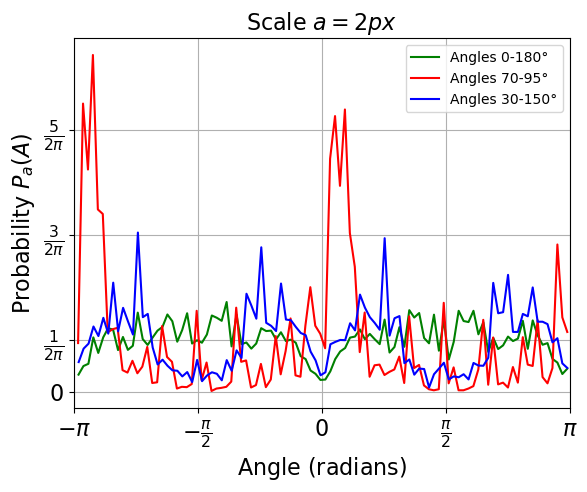

In [58]:
# Calculate the angles 
fish = WTMM.WTMM_compute(data['Phalloidin'],15,15)

# Plot the PDF as a line plot
plt.figure()
# plt.plot(fish['bin_centers'], fish['counts'], linestyle='-', marker='',label="WT Fast Muscle Fibers",color='blue')
plt.plot(sim['iso']['bin_centers'], sim['iso']['counts'], linestyle='-', marker='',label="Angles 0-180°",color='green')
plt.plot(sim['70-95']['bin_centers'], sim['70-95']['counts'], linestyle='-', marker='',label="Angles 70-95°",color='red')
plt.plot(sim['30-150']['bin_centers'], sim['30-150']['counts'], linestyle='-', marker='',label="Angles 30-150°",color='blue')
# Set x-axis limits to -π to π
plt.xlim(-np.pi, np.pi)

# add 1/(2pi) vlin
# plt.hlines(1/np.pi/2,-np.pi,np.pi,color = 'black')

# Set x-axis ticks to π values with bigger font size
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)

# # Set y-axis ticks to π values with bigger font size
plt.yticks([ 0, 1/np.pi/2, 3/2/np.pi,5/2/np.pi], 
           [ r'$0$', r'$\frac{1 }{2\pi}$', r'$\frac{3}{2\pi}$',r'$\frac{5}{2\pi}$'], fontsize=16)

# Set title with bigger font size
plt.title(f"Scale $a={sim['iso']['scale']} px$", loc="center", fontsize=16)
# plt.text(-0.5,2.8,f'Scale $a={sig1} px$')
plt.xlabel(r'$\text{Angle (radians)}$', fontsize=16)
plt.ylabel(r'Probability $P_{a}(A)$', fontsize=16)
plt.grid(True)
plt.savefig(f"Methods/angles-scale-{sim['iso']['scale']}.pdf")
plt.legend(loc='upper right')
plt.show()



## Simulate the different conditions

In [51]:
data['0-180'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[0,180]) for i in range(0,50)]
data['70-95'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[70,95]) for i in range(0,50)]
data['30-150'] = [generate_isotropic_image(num_lines=500,line_thickness=10,img_size=(750,800),orientation=[30,150]) for i in range(0,50)]
simulation = {}
# simulation['WT Fast Muscle Fibers'] = [WTMM.WTMM_compute(data['Phalloidin'],1,10)['Fa']]
simulation['0-180'] = [WTMM.WTMM_compute(i,1,10)['Fa'] for i in data['0-180']]
simulation['70-95'] = [WTMM.WTMM_compute(i,1,10)['Fa'] for i in data['70-95']]
simulation['30-150'] = [WTMM.WTMM_compute(i,1,10)['Fa'] for i in data['30-150']]

100%|██████████| 748/748 [00:00<00:00, 2645.69it/s]


In [52]:
import pandas as pd
print(simulation)
df = pd.DataFrame(simulation)
# Add the index column
df['index'] = df.index

# Convert to long format
df_long = pd.melt(df, id_vars=['index'], value_vars=['0-180', '70-95', '30-150'],
                  var_name='Angles', value_name='Values')
df_long


{'0-180': [0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046193635868, 0.5251046

,index,Angles,Values
0,0,0-180,0.525105
1,1,0-180,0.525105
2,2,0-180,0.525105
3,3,0-180,0.525105
4,4,0-180,0.525105
...,...,...,...
145,45,30-150,0.774823
146,46,30-150,0.774823
147,47,30-150,0.774823
148,48,30-150,0.774823


0-180 x 70-95                            padj: 0.0  p-val: 0.0       
0-180 x 30-150                           padj: 0.0  p-val: 0.0       
30-150 x 70-95                            padj: 0.0  p-val: 0.0       
     0-180 mean:                            0.5251046193635868
     0-180 mean:                            0.5251046193635868
    30-150 mean:                            0.7748228279779644
    30-150 mean:                            0.7748228279779644
     70-95 mean:                            1.2203275825894693
     70-95 mean:                            1.2203275825894693


/Users/quillan/anaconda3/envs/napari-env/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


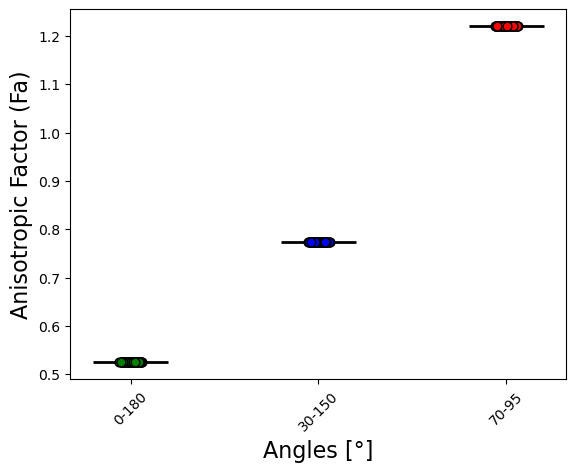

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Angles [°]', ylabel='Anisotropic Factor (Fa)'>)

In [53]:
WTMM.boxplot_delice(df_long,"Angles","Values",y_label="Anisotropic Factor (Fa)",fontsize=16,x_label="Angles [°]",point_size=40,bar_width=0.50,jitter=0.06,title_size = 50,colors=[ 'green', 'blue', 'red'],bar_edge_color='black', bar_edge_width=1.5, errorbar_width=1.5)